In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import rosbag
import pymap3d as pm
import numba as nb

from scipy.signal import savgol_filter
%matplotlib inline

Failed to load Python extension for LZ4 support. LZ4 compression will not be available.


In [2]:
def wrap_angle(angle):
    return (angle + np.pi) % (2 * np.pi) - np.pi

@nb.njit()
def to_euler(x, y, z, w):
    """Dari Coursera: Return as xyz (roll pitch yaw) Euler angles."""
    roll = np.arctan2(2 * (w * x + y * z), 1 - 2 * (x**2 + y**2))
    pitch = np.arcsin(2 * (w * y - z * x))
    yaw = np.arctan2(2 * (w * z + x * y), 1 - 2 * (y**2 + z**2))
    return np.array([roll, pitch, yaw])
# Compile the to_euler
_ = to_euler(1.5352300785980803e-15, -1.3393747145983517e-15, -0.7692164172827881, 0.638988343698562)

# Import Data

In [3]:
bag = rosbag.Bag('ukf_data/adam_0,15.bag')
print(bag)

path:        ukf_data/adam_0,15.bag
version:     2.0
duration:    27.6s
start:       Aug 22 2020 16:28:16.59 (1598088496.59)
end:         Aug 22 2020 16:28:44.18 (1598088524.18)
size:        3.4 MB
messages:    9088
compression: none [5/5 chunks]
types:       diagnostic_msgs/DiagnosticArray       [60810da900de1dd6ddd437c3503511da]
             dynamic_reconfigure/Config            [958f16a05573709014982821e6822580]
             dynamic_reconfigure/ConfigDescription [757ce9d44ba8ddd801bb30bc456f946f]
             geometry_msgs/TwistStamped            [98d34b0043a2093cf9d9345ab6eef12e]
             nav_msgs/Odometry                     [cd5e73d190d741a2f92e81eda573aca7]
             pkg_ta/Control                        [f3ff5e621674977340f826fa8303fddf]
             pkg_ta/LogArduino                     [794f6f831f1064c1b29b65087ebb232f]
             rosgraph_msgs/Log                     [acffd30cd6b6de30f120938c17c593fb]
             sensor_msgs/Imu                       [6a62c6daae103

## Speed

In [4]:
f_t = []
f_x = []
f_y = []
f_yaw = []
f_v = []
for topic, msg, _ in bag.read_messages(topics=['/odometry/filtered_map']):
    f_t.append(msg.header.stamp.to_sec())
    pos = msg.pose.pose.position
    f_x.append(pos.x)
    f_y.append(pos.y)
    q = msg.pose.pose.orientation
    euler = to_euler(q.x, q.y, q.z, q.w)
    f_yaw.append(euler[-1])
    v = msg.twist.twist.linear
    f_v.append(np.sqrt(v.x**2 + v.y**2))
f_t = np.array(f_t)
f_x = np.array(f_x)
f_y = np.array(f_y)
f_yaw = np.array(f_yaw)
f_v = np.array(f_v)
f_v[f_v < 0.] = 0.

## Control Signal

In [5]:
cs_t = []
cs_action_throttle = []
for topic, msg, _ in bag.read_messages(topics=['/control_signal']):
    cs_t.append(msg.header.stamp.to_sec())
    cs_action_throttle.append(msg.action_throttle)
cs_t = np.array(cs_t)
cs_action_throttle = np.array(cs_action_throttle)

## GPS

In [6]:
lat0, lon0, h0 = -6.8712, 107.5738, 768
gps_t = []
gps_pos = []
gps_cov = []
for topic, msg, _ in bag.read_messages(topics=['/fix']):
    gps_t.append(msg.header.stamp.to_sec())
    gps_pos.append(pm.geodetic2enu(msg.latitude, msg.longitude, msg.altitude, lat0, lon0, h0))
    gps_cov.append(msg.position_covariance)
gps_t = np.array(gps_t)
gps_pos = np.array(gps_pos)
gps_cov = np.array(gps_cov).reshape(-1,3,3)

# Get Data

## Check

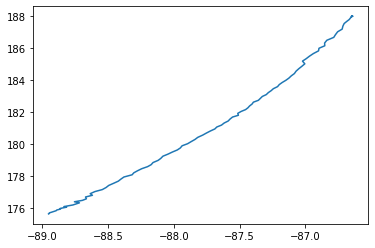

In [7]:
plt.plot(gps_pos[:,0], gps_pos[:,1])

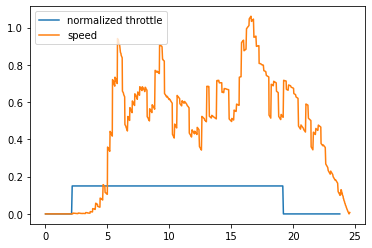

In [8]:
plt.plot(cs_t - f_t[0], cs_action_throttle, label='normalized throttle')
plt.plot(f_t - f_t[0], f_v, label='speed')
plt.legend()
plt.show()

## Align the time frame

In [9]:
idx = 0
f_throttle = np.zeros_like(f_t)
for i in range(1, f_t.shape[0]):
    f_throttle[i] = f_throttle[i-1]
    if (idx != cs_t.shape[0]):
        if (cs_t[idx] <= f_t[i]):
            f_throttle[i] = cs_action_throttle[idx]
            idx += 1

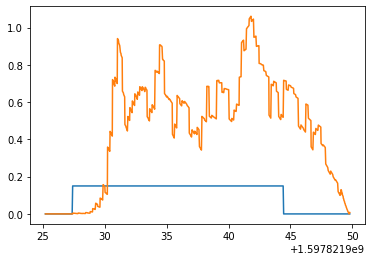

In [10]:
plt.plot(f_t, f_throttle)
plt.plot(f_t, f_v)

## Save to a .csv file

In [11]:
data = {'f_t': f_t,
        'f_v': f_v,
        'f_u': f_throttle}
df = pd.DataFrame (data, columns = ['f_t','f_v','f_u'])
df.to_csv('csv/0,15')
df.head()

,f_t,f_v,f_u
0,1.597822e+09,6.967514e-13,0.0
1,1.597822e+09,5.699555e-13,0.0
2,1.597822e+09,6.356330e-13,0.0
3,1.597822e+09,6.604265e-13,0.0
4,1.597822e+09,6.915332e-13,0.0
